In [254]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
import pickle
import random
from collections import Counter, defaultdict
from sklearn.model_selection import StratifiedShuffleSplit

In [255]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [256]:
def pad_collate(batch):
  (xx, yy) = zip(*batch)
  x_lens = [len(x) for x in xx]
  y_lens = [len(y) for y in yy]

  xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
  yy_pad = pad_sequence(yy, batch_first=True, padding_value=0)

  return xx_pad, yy_pad, x_lens, y_lens

In [257]:
with open('train.pkl', 'rb') as f:
    data = pickle.load(f)

print(data[0])

(array([ -1.,  -1.,  -1., ...,  78.,  40., 144.]), 0)


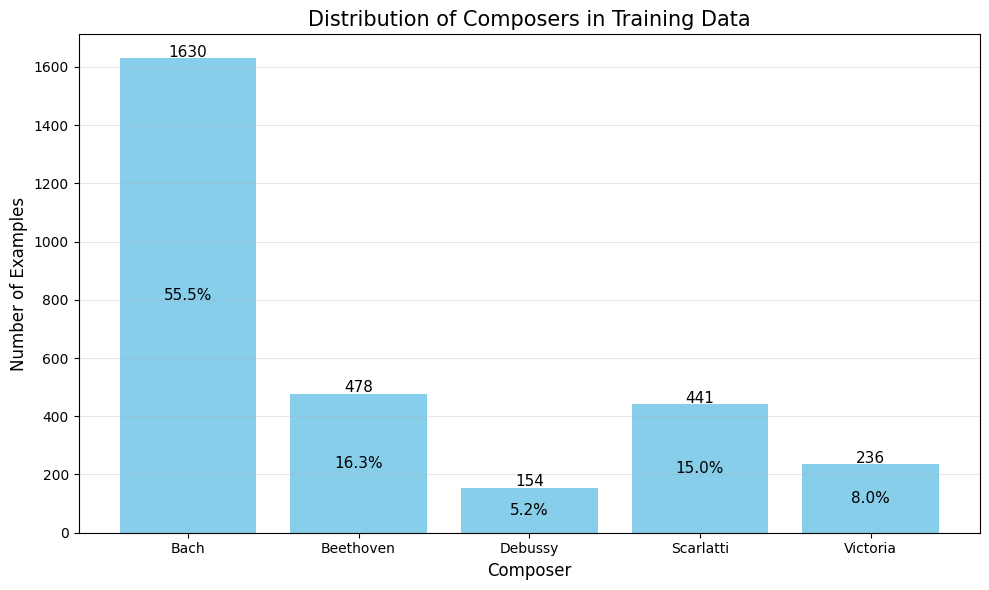

In [258]:
# Count how many examples we have for each composer
composer_counts = Counter([label for _, label in data])
composer_names = {0: 'Bach', 1: 'Beethoven', 2: 'Debussy', 3: 'Scarlatti', 4: 'Victoria'}

# Create plot for composer distribution
plt.figure(figsize=(10, 6))
composers = [composer_names[i] for i in sorted(composer_counts.keys())]
counts = [composer_counts[i] for i in sorted(composer_counts.keys())]

# Create bar chart for composer distribution
bars = plt.bar(composers, counts, color='skyblue')
plt.title('Distribution of Composers in Training Data', fontsize=15)
plt.xlabel('Composer', fontsize=12)
plt.ylabel('Number of Examples', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{int(height)}', ha='center', fontsize=11)

# Add percentage labels inside each bar
total_examples = sum(counts)
for i, bar in enumerate(bars):
    height = bar.get_height()
    percentage = (height / total_examples) * 100
    plt.text(bar.get_x() + bar.get_width()/2., height/2,
            f'{percentage:.1f}%', ha='center', va='center', fontsize=11, color='black')

plt.tight_layout()
plt.show()

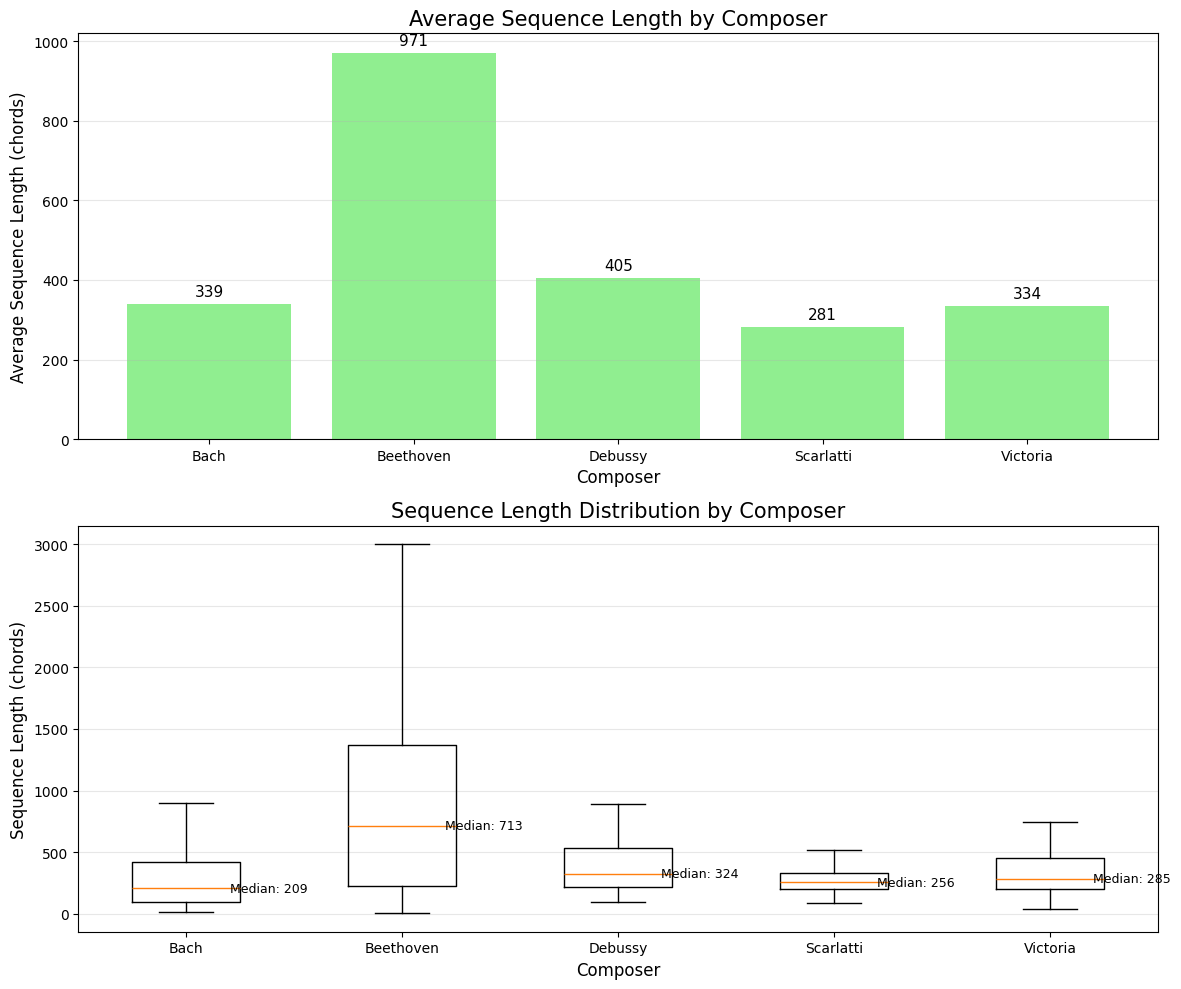


Sequence Length Statistics by Composer:
--------------------------------------------------
Composer   Min      Median   Mean     Max     
--------------------------------------------------
Bach       12       209      339      5322    
Beethoven  4        713      971      6308    
Debussy    98       324      405      2219    
Scarlatti  87       256      281      1232    
Victoria   40       285      334      992     


In [259]:
# Calculate average sequence lengths by composer
seq_lengths_by_composer = defaultdict(list)
for sequence, label in data:
    seq_lengths_by_composer[label].append(len(sequence))

# Calculate statistics
avg_lengths = {composer: np.mean(lengths) for composer, lengths in seq_lengths_by_composer.items()}
median_lengths = {composer: np.median(lengths) for composer, lengths in seq_lengths_by_composer.items()}
min_lengths = {composer: np.min(lengths) for composer, lengths in seq_lengths_by_composer.items()}
max_lengths = {composer: np.max(lengths) for composer, lengths in seq_lengths_by_composer.items()}

# Create a figure for sequence length analysis
plt.figure(figsize=(12, 10))

# Average sequence length by composer
plt.subplot(2, 1, 1)
composers_sorted = [composer_names[i] for i in sorted(avg_lengths.keys())]
avg_values = [avg_lengths[i] for i in sorted(avg_lengths.keys())]

bars = plt.bar(composers_sorted, avg_values, color='lightgreen')
plt.title('Average Sequence Length by Composer', fontsize=15)
plt.xlabel('Composer', fontsize=12)
plt.ylabel('Average Sequence Length (chords)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add average length labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 20,
            f'{int(height)}', ha='center', fontsize=11)

# Box plot of sequence length distributions
plt.subplot(2, 1, 2)
box_data = [seq_lengths_by_composer[i] for i in sorted(seq_lengths_by_composer.keys())]
plt.boxplot(box_data, tick_labels=composers_sorted, showfliers=False)
plt.title('Sequence Length Distribution by Composer', fontsize=15)
plt.xlabel('Composer', fontsize=12)
plt.ylabel('Sequence Length (chords)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add annotations for min, median, and max
for i, composer_id in enumerate(sorted(seq_lengths_by_composer.keys())):
    composer = composer_names[composer_id]
    median = median_lengths[composer_id]
    plt.text(i+1.2, median, f'Median: {int(median)}', va='center', fontsize=9)

plt.tight_layout()
plt.show()


# Print summary statistics
print("\nSequence Length Statistics by Composer:")
print("-" * 50)
print(f"{'Composer':<10} {'Min':<8} {'Median':<8} {'Mean':<8} {'Max':<8}")
print("-" * 50)
for composer_id in sorted(seq_lengths_by_composer.keys()):
    composer = composer_names[composer_id]
    min_len = min_lengths[composer_id]
    median_len = median_lengths[composer_id]
    avg_len = avg_lengths[composer_id]
    max_len = max_lengths[composer_id]
    print(f"{composer:<10} {int(min_len):<8} {int(median_len):<8} {int(avg_len):<8} {int(max_len):<8}")


Minimum sequence length: 4
Maximum sequence length: 6308
Average sequence length: 436.50
Median sequence length: 264.0


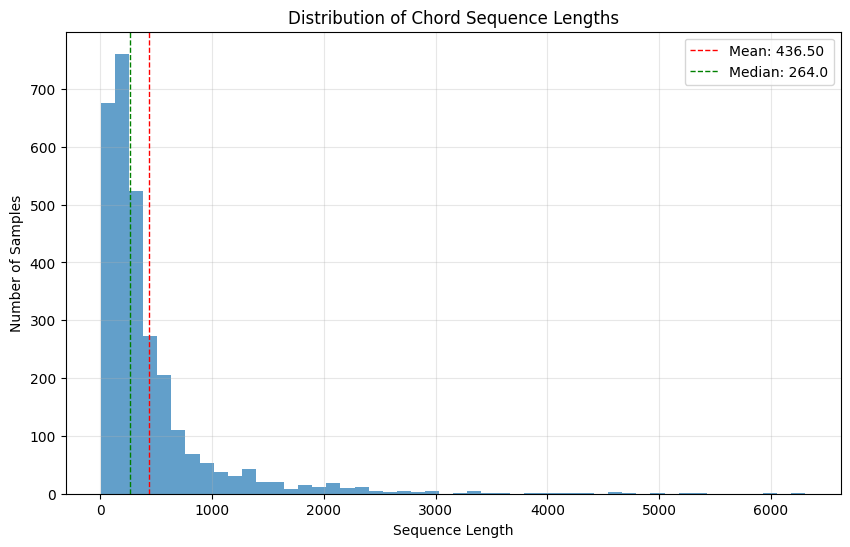


Statistics for Bach:
  Number of pieces: 1630
  Average length: 339.34
  Median length: 209.0
  Min length: 12
  Max length: 5322

Statistics for Beethoven:
  Number of pieces: 478
  Average length: 971.01
  Median length: 713.5
  Min length: 4
  Max length: 6308

Statistics for Debussy:
  Number of pieces: 154
  Average length: 405.77
  Median length: 324.5
  Min length: 98
  Max length: 2219

Statistics for Scarlatti:
  Number of pieces: 441
  Average length: 281.53
  Median length: 256.0
  Min length: 87
  Max length: 1232

Statistics for Victoria:
  Number of pieces: 236
  Average length: 334.64
  Median length: 285.0
  Min length: 40
  Max length: 992


In [260]:
sequence_lengths = [len(seq) for seq, _ in data]

min_length = min(sequence_lengths)
max_length = max(sequence_lengths)
avg_length = np.mean(sequence_lengths)
median_length = np.median(sequence_lengths)

print(f"Minimum sequence length: {min_length}")
print(f"Maximum sequence length: {max_length}")
print(f"Average sequence length: {avg_length:.2f}")
print(f"Median sequence length: {median_length}")

plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=50, alpha=0.7)
plt.axvline(avg_length, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {avg_length:.2f}')
plt.axvline(median_length, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_length}')
plt.xlabel('Sequence Length')
plt.ylabel('Number of Samples')
plt.title('Distribution of Chord Sequence Lengths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Check the length distribution for each composer
composers = ['bach', 'beethoven', 'debussy', 'scarlatti', 'victoria']
composer_lengths = {composer: [] for composer in composers}

for seq, label in data:
    composer_lengths[composers[label]].append(len(seq))

# Show statistics for each composer
for composer, lengths in composer_lengths.items():
    print(f"\nStatistics for {composer.capitalize()}:")
    print(f"  Number of pieces: {len(lengths)}")
    print(f"  Average length: {np.mean(lengths):.2f}")
    print(f"  Median length: {np.median(lengths)}")
    print(f"  Min length: {min(lengths)}")
    print(f"  Max length: {max(lengths)}")

In [ ]:
# Functions for data augmentation

def dropout_sequence(sequence, drop_prob=0.1):
    mask = np.random.rand(len(sequence)) > drop_prob
    return sequence[mask]


def local_shuffle(sequence, max_span=2):
    seq = sequence.copy()
    start = np.random.randint(0, len(seq) - max_span)
    end = start + max_span
    np.random.shuffle(seq[start:end])
    return seq


def noisy_sequence(sequence, noise_level=1):
    noise = np.random.randint(-noise_level, noise_level + 1, size=sequence.shape)
    return np.clip(sequence + noise, 0, 127)

In [ ]:
class ChordSequenceDataset(Dataset):
    def __init__(self, data, augment=False):
        self.data = data
        self.augment = augment
        self.label_map = {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sequence, label = self.data[idx]
        sequence = sequence.copy()
        
        if self.augment:
            if np.random.rand() < 0.3:
                sequence = noisy_sequence(sequence, noise_level=1.0)
            if np.random.rand() < 0.3:
                sequence = dropout_sequence(sequence, drop_prob=0.1)
            if np.random.rand() < 0.3:
                sequence = local_shuffle(sequence)
        
        sequence = torch.from_numpy(sequence).float()
        sequence = sequence + 1  # shift so -1.0 → 0
        sequence = sequence.long()
        return sequence, label


In [262]:
def pad_collate(batch):
    sequences, labels = zip(*batch)
    lengths = [len(seq) for seq in sequences]
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels = torch.tensor(labels, dtype=torch.long)
    return padded_sequences, labels, lengths

In [263]:
full_train_dataset = ChordSequenceDataset(data, augment=True)
full_test_dataset = ChordSequenceDataset(data, augment=False)

all_labels = [label for _, label in full_train_dataset]
all_labels = np.array(all_labels)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(np.zeros(len(all_labels)), all_labels):
    train_indices = train_idx
    test_indices = test_idx

train_dataset = Subset(full_train_dataset, train_indices)
test_dataset = Subset(full_test_dataset, test_indices)

train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=128, shuffle=True, collate_fn=pad_collate
)

test_dataloader = DataLoader(
    dataset=test_dataset, batch_size=128, shuffle=False, collate_fn=pad_collate
)

print(f"Oryginalny rozmiar zbioru treningowego: {len(train_dataset)}")
print(f"Rozmiar zbioru testowego: {len(test_dataset)}")

Oryginalny rozmiar zbioru treningowego: 2351
Rozmiar zbioru testowego: 588


In [264]:
class ComposerClassifier(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim, hidden_size, num_layers_lstm=3, num_classes=5
    ):
        super(ComposerClassifier, self).__init__()

        PAD_IDX = 0
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_IDX)

        self.hidden_size = hidden_size
        self.num_layers = num_layers_lstm
        self.num_directions = 2  # bidirectional

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=True,
        )

        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x, lengths):
        x = self.embedding(x)

        # Pack padded sequences
        packed = pack_padded_sequence(
            x, lengths, batch_first=True, enforce_sorted=False
        )
        _, (hidden, _) = self.lstm(packed)

        final_hidden = torch.cat([hidden[0], hidden[1]], dim=1)

        output = self.fc(final_hidden)
        return output

In [265]:
def compute_vocab_size(data):
    unique_values = set()
    for sequence, _ in data:
        unique_values.update(sequence.tolist())
    return int(max(unique_values)) + 2  # Zakładamy, że ID są od 0 do max

vocab_size = compute_vocab_size(data)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 193


In [266]:
model = ComposerClassifier(
    vocab_size=vocab_size,
    embedding_dim=64,
    hidden_size=128,
    num_layers_lstm=3,
    num_classes=5,
).to(device)

In [267]:
class_counts = Counter(all_labels)
class_weights = torch.tensor([
    len(all_labels) / (len(class_counts) * class_counts[i]) 
    for i in range(5)
]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch [1/40], Train Loss: 1.5533, Test Loss: 1.4680, Test Acc: 45.07%, Test F1: 0.3522
Epoch [2/40], Train Loss: 1.3734, Test Loss: 1.2641, Test Acc: 59.18%, Test F1: 0.4576
Epoch [3/40], Train Loss: 1.1684, Test Loss: 1.0981, Test Acc: 58.16%, Test F1: 0.4857
Epoch [4/40], Train Loss: 1.0047, Test Loss: 0.9534, Test Acc: 65.99%, Test F1: 0.5719
Epoch [5/40], Train Loss: 0.9022, Test Loss: 0.9181, Test Acc: 70.24%, Test F1: 0.6098
Epoch [6/40], Train Loss: 0.8176, Test Loss: 0.8299, Test Acc: 70.58%, Test F1: 0.6230
Epoch [7/40], Train Loss: 0.7472, Test Loss: 0.8134, Test Acc: 74.83%, Test F1: 0.6542
Epoch [8/40], Train Loss: 0.6928, Test Loss: 0.7021, Test Acc: 72.11%, Test F1: 0.6594
Epoch [9/40], Train Loss: 0.6402, Test Loss: 0.6920, Test Acc: 76.02%, Test F1: 0.6886
Epoch [10/40], Train Loss: 0.6190, Test Loss: 0.6517, Test Acc: 80.27%, Test F1: 0.7176
Epoch [11/40], Train Loss: 0.5374, Test Loss: 0.6572, Test Acc: 75.85%, Test F1: 0.6755
Epoch [12/40], Train Loss: 0.5256, Test L

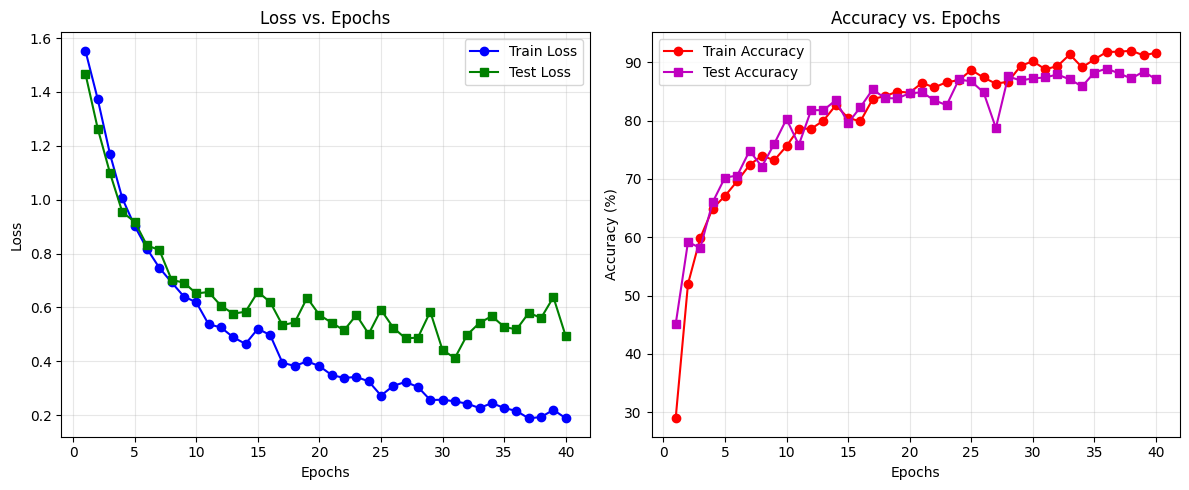

In [268]:
from sklearn.metrics import f1_score

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
test_f1_scores = []

num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (sequences, labels, lengths) in enumerate(train_dataloader):
        sequences = sequences.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(sequences, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataloader)
    accuracy = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

    # Ewaluacja
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels, lengths in test_dataloader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            outputs = model(sequences, lengths)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_epoch_loss = test_running_loss / len(test_dataloader)
    test_accuracy = 100 * test_correct / test_total
    test_f1 = f1_score(all_labels, all_preds, average="macro")

    test_losses.append(test_epoch_loss)
    test_accuracies.append(test_accuracy)
    test_f1_scores.append(test_f1)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], "
        f"Train Loss: {epoch_loss:.4f}, "
        f"Test Loss: {test_epoch_loss:.4f}, Test Acc: {test_accuracy:.2f}%, "
        f"Test F1: {test_f1:.4f}"
    )

torch.save(model.state_dict(), "composer_classifier_good2.pth")
print("Model saved as 'composer_classifier_good2.pth'")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, "b-", marker="o", label="Train Loss")
plt.plot(range(1, num_epochs + 1), test_losses, "g-", marker="s", label="Test Loss")
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(
    range(1, num_epochs + 1), train_accuracies, "r-", marker="o", label="Train Accuracy"
)
plt.plot(
    range(1, num_epochs + 1), test_accuracies, "m-", marker="s", label="Test Accuracy"
)
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

Test Loss: 0.4929, Test Accuracy: 87.07%
F1 Score (macro): 0.8047

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       326
           1       0.76      0.78      0.77        96
           2       0.57      0.65      0.61        31
           3       0.76      0.78      0.77        88
           4       0.88      0.98      0.93        47

    accuracy                           0.87       588
   macro avg       0.79      0.82      0.80       588
weighted avg       0.88      0.87      0.87       588



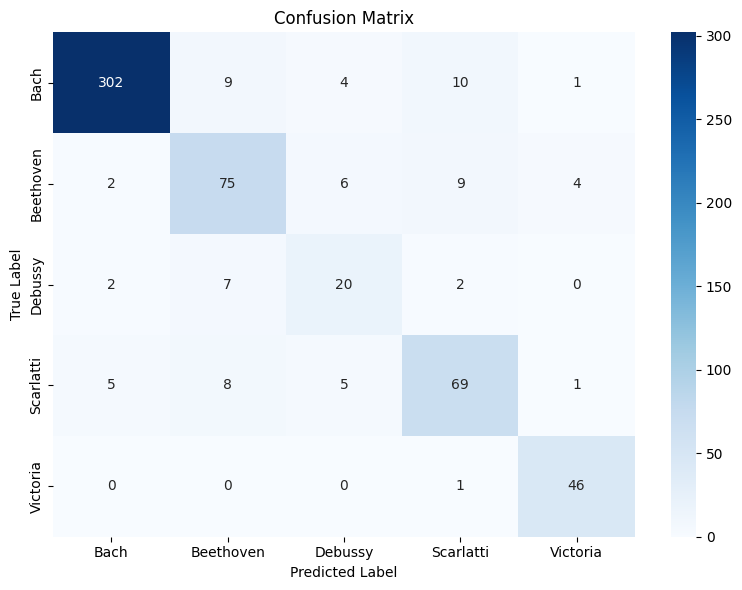

In [273]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

model.eval()  
test_correct = 0
test_total = 0
all_predictions = []
all_labels = []
test_loss = 0.0

with torch.no_grad(): 
    for sequences, labels, lengths in test_dataloader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        outputs = model(sequences, lengths)
        
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Obliczenia
test_accuracy = 100 * test_correct / test_total
avg_test_loss = test_loss / len(test_dataloader)

# Konwersja do numpy
y_true = np.array(all_labels)
y_pred = np.array(all_predictions)

# F1-score i confusion matrix
f1_macro = f1_score(y_true, y_pred, average='macro')  # 'macro' traktuje wszystkie klasy równo
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred)

# Wyniki
print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
print(f'F1 Score (macro): {f1_macro:.4f}')
print("\nClassification Report:\n", report)

class_names = ['Bach', 'Beethoven', 'Debussy', 'Scarlatti', 'Victoria']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Generowanie predykcji

In [279]:
class TestDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        sequence = torch.from_numpy(sequence).float()
        sequence = sequence + 1  # shift so -1.0 → 0
        sequence = sequence.long()
        return sequence

In [280]:
def test_pad_collate(batch):
    sequences = batch
    lengths = [len(seq) for seq in sequences]
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)
    return padded_sequences, lengths

In [281]:
with open('test_no_target.pkl', 'rb') as f:
    test_data = pickle.load(f)

test_dataset = TestDataset(test_data)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=test_pad_collate
)

In [282]:
def predict_composers(model, data_loader, device):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for sequences, lengths in data_loader:
            sequences = sequences.to(device)
            outputs = model(sequences, lengths)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    
    return predictions

In [283]:
predictions = predict_composers(model, test_loader, device)
composer_names = {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}
predicted_composers = [composer_names[pred] for pred in predictions]

with open('pred.csv', 'w') as f:
    for composer in predicted_composers:
        f.write(f"{composer}\n")